In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Part 1: Data Preparation and Exploration

# Load the data
data = pd.read_csv('/content/exchange_rate.csv')

print(data.columns)


# Display basic info
data.info()
print(data.head())


Index(['date', 'Ex_rate'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB
               date  Ex_rate
0  01-01-1990 00:00   0.7855
1  02-01-1990 00:00   0.7818
2  03-01-1990 00:00   0.7867
3  04-01-1990 00:00   0.7860
4  05-01-1990 00:00   0.7849


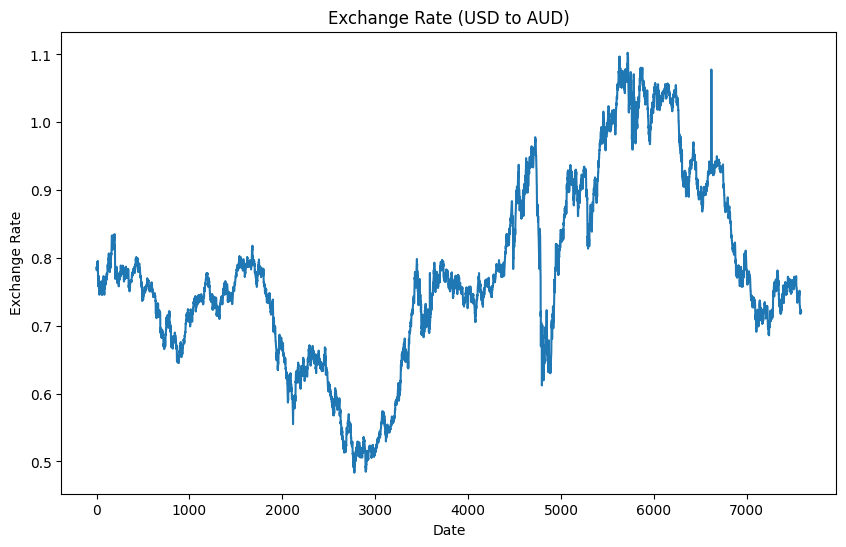

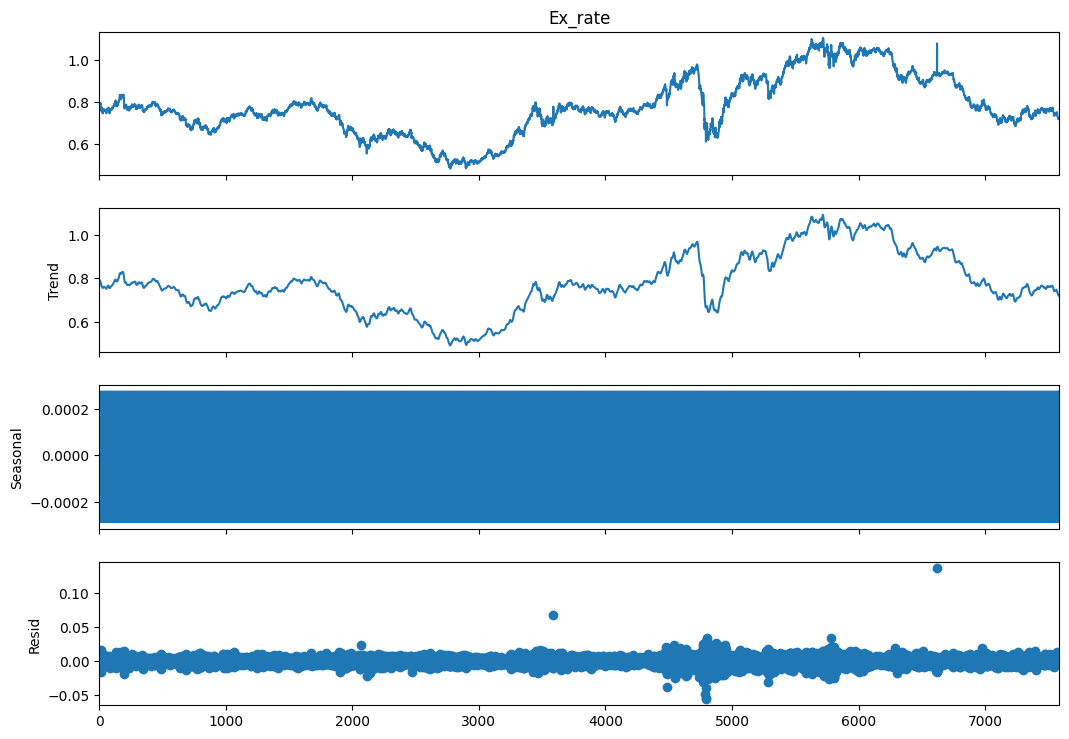

In [ ]:
# Plot the time series for initial exploration
plt.figure(figsize=(10, 6))
data['Ex_rate'].plot(title='Exchange Rate (USD to AUD)', ylabel='Exchange Rate', xlabel='Date') # Changed 'Ex_Rate' to 'Ex_rate'
plt.show()

# Decompose the time series
decomposition = seasonal_decompose(data['Ex_rate'], model='additive', period=12) # Changed 'Ex_Rate' to 'Ex_rate'
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

In [ ]:
# Check for missing values and handle them
if data.isnull().values.any():
    data = data.fillna(method='ffill').fillna(method='bfill')

# Perform ADF test to check stationarity
adf_test = adfuller(data['Ex_rate']) # Changed 'Ex_Rate' to 'Ex_rate'
print(f"ADF Statistic: {adf_test[0]}\nP-Value: {adf_test[1]}")
if adf_test[1] > 0.05:
    print("Data is not stationary, differencing is required.")
else:
    print("Data is stationary.")

ADF Statistic: -1.6649941807382342
P-Value: 0.4492327353597477
Data is not stationary, differencing is required.


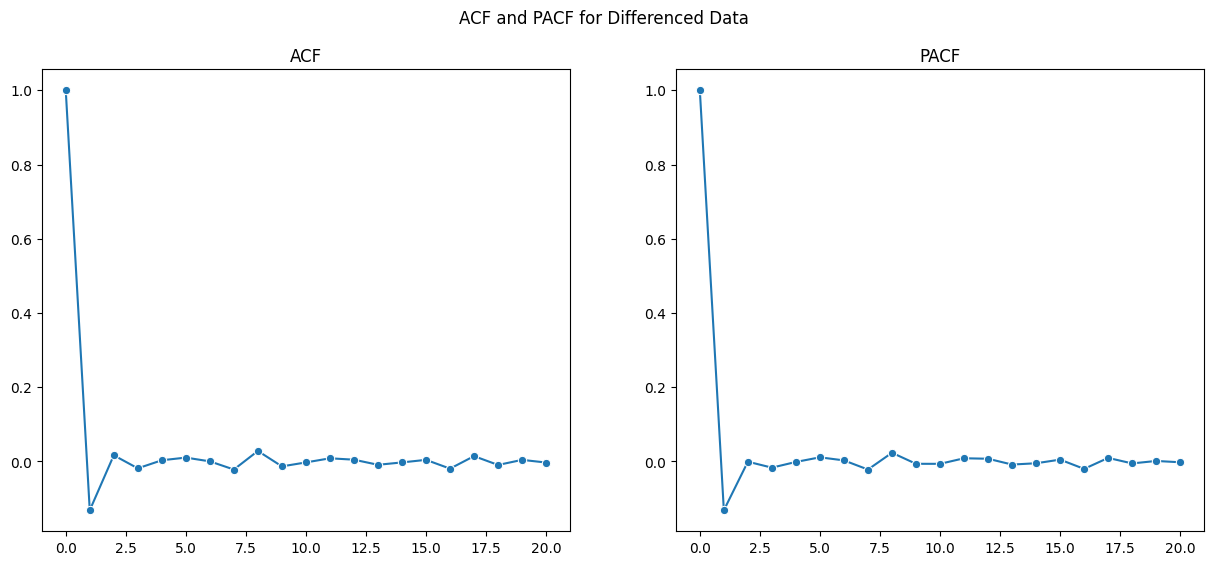

In [ ]:
data_diff = data['Ex_rate'].diff().dropna()

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("ACF and PACF for Differenced Data")
sns.lineplot(ax=axes[0], x=np.arange(len(acf(data_diff, nlags=20))), y=acf(data_diff, nlags=20), marker='o')
axes[0].set_title('ACF')
sns.lineplot(ax=axes[1], x=np.arange(len(pacf(data_diff, nlags=20))), y=pacf(data_diff, nlags=20), marker='o')
axes[1].set_title('PACF')
plt.show()


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Fri, 27 Dec 2024   AIC                         -56102.322
Time:                        14:39:46   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

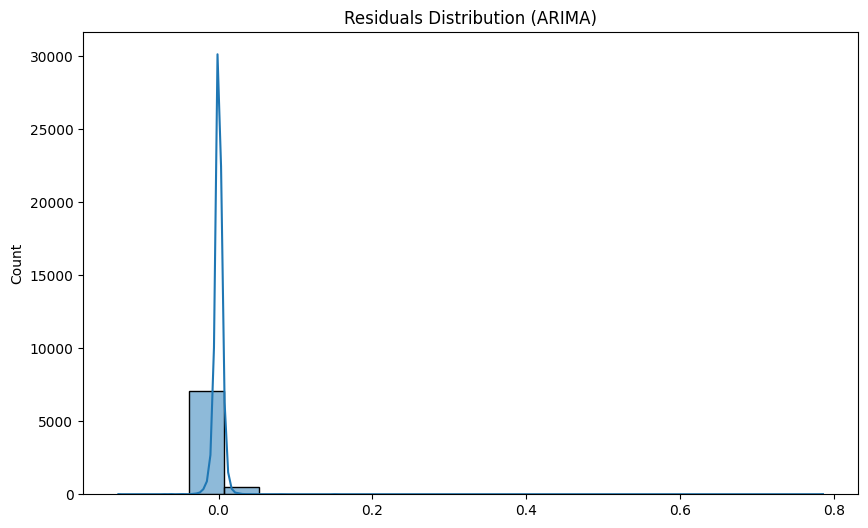

In [ ]:
# Fit ARIMA model
p, d, q = 1, 1, 1  # Adjust based on ACF/PACF plots
arima_model = ARIMA(data['Ex_rate'], order=(p, d, q))
arima_fitted = arima_model.fit()
print(arima_fitted.summary())

# Diagnostics
arima_residuals = arima_fitted.resid
plt.figure(figsize=(10, 6))
sns.histplot(arima_residuals, kde=True, bins=20)
plt.title('Residuals Distribution (ARIMA)')
plt.show()

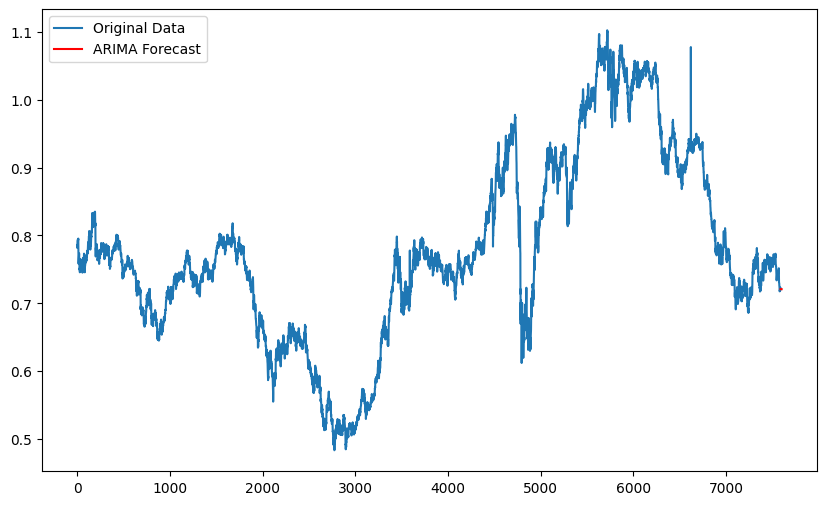

In [ ]:
# Forecasting
forecast_arima = arima_fitted.forecast(steps=12)
plt.figure(figsize=(10, 6))
plt.plot(data['Ex_rate'], label='Original Data')
plt.plot(forecast_arima.index, forecast_arima, label='ARIMA Forecast', color='red')
plt.legend()
plt.show()

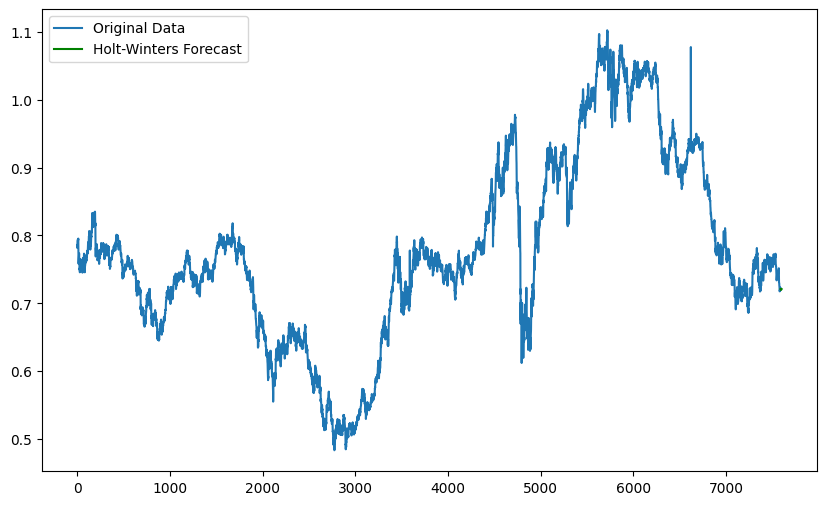

In [ ]:

# Fit Holt-Winters Exponential Smoothing
hw_model = ExponentialSmoothing(data['Ex_rate'], seasonal='add', seasonal_periods=12).fit()
hw_forecast = hw_model.forecast(12)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(data['Ex_rate'], label='Original Data')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Forecast', color='green')
plt.legend()
plt.show()


In [ ]:
# Compute Error Metrics
def compute_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{model_name} Error Metrics:\nMAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

# Assuming 12 months of true values available for comparison (adjust indices as needed)
y_true = data['Ex_rate'][-12:]
y_arima = forecast_arima[:12]
y_hw = hw_forecast[:12]

compute_metrics(y_true, y_arima, "ARIMA")
compute_metrics(y_true, y_hw, "Holt-Winters")

ARIMA Error Metrics:
MAE: 0.0017, RMSE: 0.0020, MAPE: nan%
Holt-Winters Error Metrics:
MAE: 0.0016, RMSE: 0.0019, MAPE: nan%


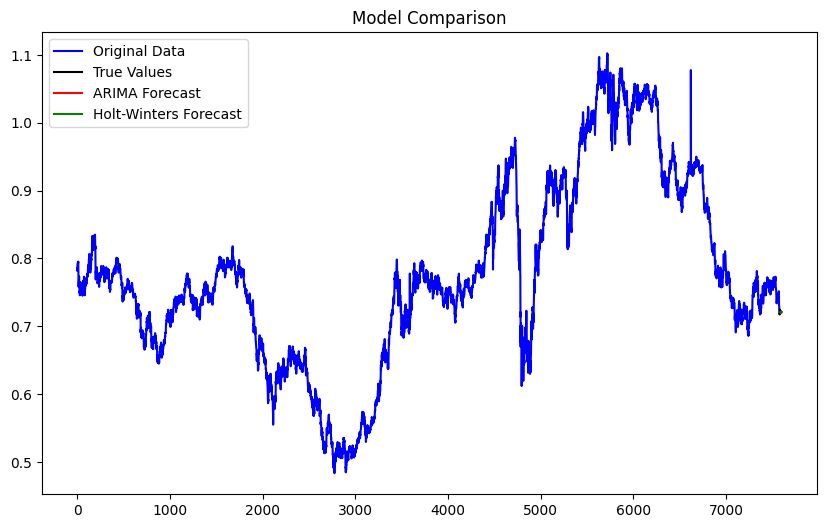

In [ ]:
# Model Comparison
plt.figure(figsize=(10, 6))
plt.plot(data['Ex_rate'], label='Original Data', color='blue')
plt.plot(y_true.index, y_true, label='True Values', color='black')
plt.plot(y_arima.index, y_arima, label='ARIMA Forecast', color='red')
plt.plot(y_hw.index, y_hw, label='Holt-Winters Forecast', color='green')
plt.legend()
plt.title('Model Comparison')
plt.show()